<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Admin-Boarders-data" data-toc-modified-id="Load-Admin-Boarders-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Admin Boarders data</a></span></li><li><span><a href="#Roads-&amp;-Streets" data-toc-modified-id="Roads-&amp;-Streets-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Roads &amp; Streets</a></span><ul class="toc-item"><li><span><a href="#Streets" data-toc-modified-id="Streets-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Streets</a></span></li><li><span><a href="#Roads" data-toc-modified-id="Roads-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Roads</a></span></li></ul></li><li><span><a href="#Upload-to-BQ" data-toc-modified-id="Upload-to-BQ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Upload to BQ</a></span></li></ul></div>

In [10]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

from google.cloud import bigquery
from google.oauth2 import service_account


# Load Admin Boarders data

In [41]:
service_account_path = '/Users/Moe/code/moe221/gcp/taqarib-453c46fd0910.json'

# Authenticate and create a BigQuery client
credentials = service_account.Credentials.from_service_account_file(service_account_path)
client = bigquery.Client(credentials=credentials, project=credentials.project_id)



In [45]:
project_id = 'taqarib'
dataset_id = 'taqarib'
table_id = 'taqarib_admin_lvl_1_pop'

query = f"""SELECT *
            FROM `{project_id}.{dataset_id}.{table_id}`
            """

df_admin_lvl_1 = client.query(query).to_dataframe()



In [46]:
df_admin_lvl_1.head()

,Shape_Area,geometry,Shape_Length,area_sqkm,geo_ar,population,age_group,adm_code_lvl_1,sex,country,admin_lvl_1_ar,admin_lvl_1,geo
0,2.019833,"POLYGON((22.1770325 32.9030037, 22.176857 32.9...",6.349797,21185.15,الشرق,53315,18-59,LY0101,Female,LIBYA,درنه,Derna,East
1,2.019833,"POLYGON((22.1770325 32.9030037, 22.176857 32.9...",6.349797,21185.15,الشرق,5215,60 and older,LY0101,Female,LIBYA,درنه,Derna,East
2,2.019833,"POLYGON((22.1770325 32.9030037, 22.176857 32.9...",6.349797,21185.15,الشرق,45638,under 18,LY0101,Female,LIBYA,درنه,Derna,East
3,2.019833,"POLYGON((22.1770325 32.9030037, 22.176857 32.9...",6.349797,21185.15,الشرق,53480,18-59,LY0101,Male,LIBYA,درنه,Derna,East
4,2.019833,"POLYGON((22.1770325 32.9030037, 22.176857 32.9...",6.349797,21185.15,الشرق,5243,60 and older,LY0101,Male,LIBYA,درنه,Derna,East


In [47]:
#keep only distric info

df_admin_lvl_1 = df_admin_lvl_1[['country',
                                    'geo',
                                    'geo_ar',
                                    'admin_lvl_1',
                                    'admin_lvl_1_ar',
                                    'adm_code_lvl_1',
                                    'geometry',
                                    'area_sqkm']].drop_duplicates(keep="first")



# Roads & Streets

In [7]:
streets_path = "../data/Roads_and_Streets/lby_trs_streets_osm/"
roads_path = "../data/Roads_and_Streets/lby_trs_roads_osm"

df_streets = gpd.read_file(streets_path)
df_roads = gpd.read_file(roads_path)


In [9]:
df_streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 219304 entries, 0 to 219303
Data columns (total 21 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   objectid    219304 non-null  int64   
 1   osm_id      219304 non-null  float64 
 2   sourceid    0 non-null       object  
 3   notes       6 non-null       object  
 4   onme        0 non-null       object  
 5   rtenme      1378 non-null    object  
 6   ntlclass    219304 non-null  object  
 7   fclass      219304 non-null  int64   
 8   numlanes    162 non-null     float64 
 9   srftpe      18135 non-null   object  
 10  srfcond     744 non-null     object  
 11  isseasonal  0 non-null       object  
 12  curntprac   0 non-null       object  
 13  gnralspeed  1023 non-null    float64 
 14  rdwidthm    27 non-null      float64 
 15  status      0 non-null       object  
 16  iselevated  219304 non-null  int64   
 17  iso3        219304 non-null  object  
 18  country     2193

## Streets

In [48]:
# keep only needed columns
df_streets = df_streets[['objectid',
            'osm_id',
            'ntlclass',
            'fclass',
            'numlanes',
            'srftpe',
            'srfcond',
            'gnralspeed',
            'rdwidthm',
            'iselevated',
            'last_updat',
            'geometry']]

In [49]:
df_admin_lvl_1["geometry"] = df_admin_lvl_1["geometry"].apply(wkt.loads)


In [50]:
# convert to geodataframes
df_admin_lvl_1_geo = gpd.GeoDataFrame(df_admin_lvl_1).copy()
df_streets_geo = gpd.GeoDataFrame(df_streets).copy()


In [51]:
# Ensure both GeoDataFrames use the same CRS
df_streets_geo["geometry"] = df_streets_geo["geometry"].set_crs("EPSG:4326")
df_admin_lvl_1_geo["geometry"] = df_admin_lvl_1_geo["geometry"].set_crs("EPSG:4326")


In [56]:
# Perform the spatial join
# This will assign each road to a district based on intersection
streets_with_districts = gpd.sjoin(df_streets_geo,
                                 df_admin_lvl_1_geo,
                                 how="left",
                                 predicate='intersects')


streets_with_districts.drop(columns=["index_right"], inplace=True)
streets_with_districts.drop_duplicates(keep="first", inplace=True)

In [57]:
streets_with_districts.head()

,objectid,osm_id,ntlclass,fclass,numlanes,srftpe,srfcond,gnralspeed,rdwidthm,iselevated,last_updat,geometry,country,geo,geo_ar,admin_lvl_1,admin_lvl_1_ar,adm_code_lvl_1,area_sqkm
0,589,153106506.0,residential,5,NaN,None,None,NaN,NaN,0,2021-01-17 12:22:19.212,"LINESTRING (12.48731 32.79525, 12.48716 32.795...",LIBYA,West,الغرب,Zwara,زوارة,LY0215,6069.14
1,827,410985545.0,residential,5,NaN,asphalt,None,NaN,NaN,0,2021-01-17 12:22:19.212,"LINESTRING (12.48623 32.79448, 12.48566 32.794...",LIBYA,West,الغرب,Zwara,زوارة,LY0215,6069.14
2,1461,670002712.0,residential,5,NaN,None,None,NaN,NaN,0,2021-01-17 12:22:19.212,"LINESTRING (12.41461 32.80692, 12.41454 32.807...",LIBYA,West,الغرب,Zwara,زوارة,LY0215,6069.14
3,1885,894531435.0,residential,5,NaN,None,None,NaN,NaN,0,2021-01-17 12:22:19.212,"LINESTRING (11.35424 31.99503, 11.35420 31.995...",LIBYA,West,الغرب,Nalut,نالوت,LY0209,65081.01
4,2054,893784815.0,service,5,NaN,None,None,NaN,NaN,0,2021-01-17 12:22:19.212,"LINESTRING (13.99643 31.71561, 13.99596 31.715...",LIBYA,West,الغرب,Misrata,مصراته,LY0214,29216.45


In [70]:
streets_with_districts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 219870 entries, 0 to 219303
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   objectid        219870 non-null  int64   
 1   osm_id          219870 non-null  float64 
 2   ntlclass        219870 non-null  object  
 3   fclass          219870 non-null  int64   
 4   numlanes        162 non-null     float64 
 5   srftpe          18166 non-null   object  
 6   srfcond         744 non-null     object  
 7   gnralspeed      1023 non-null    float64 
 8   rdwidthm        27 non-null      float64 
 9   iselevated      219870 non-null  int64   
 10  last_updat      219870 non-null  object  
 11  geometry        219870 non-null  geometry
 12  country         219568 non-null  object  
 13  geo             219568 non-null  object  
 14  geo_ar          219568 non-null  object  
 15  admin_lvl_1     219568 non-null  object  
 16  admin_lvl_1_ar  219568 non-nul

## Roads

In [58]:
df_roads.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33335 entries, 0 to 33334
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    33335 non-null  int64   
 1   osm_id      33335 non-null  float64 
 2   sourceid    0 non-null      object  
 3   notes       228 non-null    object  
 4   onme        562 non-null    object  
 5   rtenme      4312 non-null   object  
 6   ntlclass    33335 non-null  object  
 7   fclass      33335 non-null  int64   
 8   numlanes    923 non-null    float64 
 9   srftpe      10100 non-null  object  
 10  srfcond     1079 non-null   object  
 11  isseasonal  0 non-null      object  
 12  curntprac   0 non-null      object  
 13  gnralspeed  438 non-null    float64 
 14  rdwidthm    64 non-null     float64 
 15  status      0 non-null      object  
 16  iselevated  33335 non-null  int64   
 17  iso3        33335 non-null  object  
 18  country     33335 non-null  object  
 

In [60]:
df_roads = df_roads[['objectid',
            'osm_id',
            'ntlclass',
            'fclass',
            'numlanes',
            'srftpe',
            'srfcond',
            'gnralspeed',
            'rdwidthm',
            'iselevated',
            'last_updat',
            'geometry']]

In [62]:
df_roads_geo = gpd.GeoDataFrame(df_roads).copy()
df_roads_geo["geometry"] = df_roads_geo["geometry"].set_crs("EPSG:4326")


In [63]:
# Perform the spatial join
# This will assign each road to a district based on intersection
roads_with_districts = gpd.sjoin(df_roads_geo,
                                 df_admin_lvl_1_geo,
                                 how="left",
                                 predicate='intersects')


roads_with_districts.drop(columns=["index_right"], inplace=True)
roads_with_districts.drop_duplicates(keep="first", inplace=True)

In [64]:
roads_with_districts

,objectid,osm_id,ntlclass,fclass,numlanes,srftpe,srfcond,gnralspeed,rdwidthm,iselevated,last_updat,geometry,country,geo,geo_ar,admin_lvl_1,admin_lvl_1_ar,adm_code_lvl_1,area_sqkm
0,666,101521575.0,track,6,NaN,None,None,NaN,NaN,0,2021-07-27 23:30:13.375,"LINESTRING (11.82101 32.72657, 11.82104 32.727...",LIBYA,West,الغرب,Zwara,زوارة,LY0215,6069.14
1,757,946154748.0,track,6,NaN,None,None,NaN,NaN,0,2021-07-27 23:30:13.375,"LINESTRING (11.90928 32.82862, 11.90920 32.828...",LIBYA,West,الغرب,Zwara,زوارة,LY0215,6069.14
2,1222,857431014.0,track,6,NaN,None,None,NaN,NaN,0,2021-01-17 12:22:19.212,"LINESTRING (13.94900 31.68623, 13.94976 31.685...",LIBYA,West,الغرب,Misrata,مصراته,LY0214,29216.45
3,1284,895889849.0,track,6,NaN,None,None,NaN,NaN,0,2021-01-17 12:22:19.212,"LINESTRING (12.41990 32.80430, 12.41991 32.804...",LIBYA,West,الغرب,Zwara,زوارة,LY0215,6069.14
4,1439,171935830.0,tertiary,4,NaN,unpaved,None,NaN,NaN,0,2021-07-27 23:30:13.375,"LINESTRING (11.71218 32.85056, 11.71217 32.850...",LIBYA,West,الغرب,Zwara,زوارة,LY0215,6069.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33330,15008602,658142714.0,track,6,NaN,None,None,NaN,NaN,0,2021-01-15 23:29:54.478,"LINESTRING (22.56548 32.76843, 22.56641 32.769...",LIBYA,East,الشرق,Derna,درنه,LY0101,21185.15
33331,15008603,224899339.0,unclassified,6,NaN,None,None,NaN,NaN,0,2021-01-15 23:29:54.478,"LINESTRING (22.62144 32.77115, 22.62142 32.771...",LIBYA,East,الشرق,Derna,درنه,LY0101,21185.15
33332,15008604,224889847.0,unclassified,6,NaN,asphalt,None,NaN,NaN,0,2021-01-15 23:29:54.478,"LINESTRING (22.62013 32.76882, 22.62029 32.768...",LIBYA,East,الشرق,Derna,درنه,LY0101,21185.15
33333,15008605,218727117.0,unclassified,6,NaN,asphalt,None,NaN,NaN,0,2021-01-15 23:29:54.478,"LINESTRING (22.64890 32.75879, 22.64887 32.758...",LIBYA,East,الشرق,Derna,درنه,LY0101,21185.15


In [69]:
roads_with_districts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 33840 entries, 0 to 33334
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   objectid        33840 non-null  int64   
 1   osm_id          33840 non-null  float64 
 2   ntlclass        33840 non-null  object  
 3   fclass          33840 non-null  int64   
 4   numlanes        943 non-null    float64 
 5   srftpe          10365 non-null  object  
 6   srfcond         1099 non-null   object  
 7   gnralspeed      455 non-null    float64 
 8   rdwidthm        64 non-null     float64 
 9   iselevated      33840 non-null  int64   
 10  last_updat      33840 non-null  object  
 11  geometry        33840 non-null  geometry
 12  country         33802 non-null  object  
 13  geo             33802 non-null  object  
 14  geo_ar          33802 non-null  object  
 15  admin_lvl_1     33802 non-null  object  
 16  admin_lvl_1_ar  33802 non-null  object  
 17  adm_

# Upload to BQ

In [65]:
roads_with_districts.to_file("../data/output/roads_with_districts.gpkg", driver="GPKG")
streets_with_districts.to_file("../data/output/streets_with_districts.gpkg", driver="GPKG")




In [71]:
def load_geojsonl_to_bigquery(dataset_name, table_name, file_path):
    # Path to your service account key file
    service_account_path = '/Users/Moe/code/moe221/gcp/taqarib-453c46fd0910.json'

    # Authenticate and create a BigQuery client
    credentials = service_account.Credentials.from_service_account_file(service_account_path)
    client = bigquery.Client(credentials=credentials, project=credentials.project_id)

    # Configure the load job
    job_config = bigquery.LoadJobConfig(
        source_format=bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
        autodetect=True,
        write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
        json_extension='GEOJSON'
    )

    # Define dataset and table ID
    dataset_ref = client.dataset(dataset_name)
    table_ref = dataset_ref.table(table_name)

    # Use the file path of the GeoJSONL
    with open(file_path, "rb") as source_file:
        job = client.load_table_from_file(source_file, table_ref, job_config=job_config)

    # Wait for the job to complete
    job.result()  # Waits for table load to complete.
    print("Loaded {} rows into {}:{}".format(job.output_rows, dataset_name, table_name))



In [73]:
load_geojsonl_to_bigquery("taqarib",
                          "taqarib_admin_lvl_2_pop",
                          "/Users/Moe/code/moe221/taqarib/data/output/df_pop_lvl_2_2022_cleaned.geojsonl")


Loaded 4002 rows into taqarib:taqarib_admin_lvl_3_pop


In [68]:
load_geojsonl_to_bigquery("taqarib",
                          "taqarib_streets_with_districts",
                          "/Users/Moe/code/moe221/taqarib/data/output/streets_with_districts.geojsonl")

Loaded 219870 rows into taqarib:taqarib_streets_with_districts


In [ ]:
# Step 1: Load the data
# Assuming the relevant columns are 'geometry' for the polygons and they are stored as WKT (Well-Known Text)
data_path = '../data/GeoData/open_buildings_v3_polygons_your_own_wkt_polygon_derna.csv.gz'
df = pd.read_csv(data_path, compression='gzip')

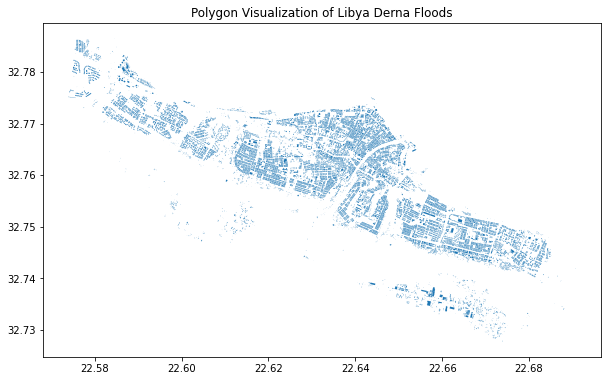

In [3]:


# Step 2: Convert DataFrame to GeoDataFrame
# Convert the 'geometry' column which contains WKT strings to actual geometry
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Set the coordinate reference system (CRS) if known, for example using EPSG code
gdf.set_crs(epsg=4326, inplace=True)  # EPSG:4326 is WGS84 Latitude/Longitude

# Step 3: Visualize the Data
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax)
plt.title('Polygon Visualization of Libya Derna Floods')
plt.show()


In [5]:


# Step 1: Read the GeoJSON file
data_path = '../data/GeoData/Libya Dams.geojson'
gdf = gpd.read_file(data_path)

# Step 2: Visualize the data
# Create a plot
fig, ax = plt.subplots(figsize=(12, 12))  # Adjust the size as needed
gdf.plot(ax=ax, color='blue')  # You can change color and other styling options

# Adding titles and labels
plt.title('Dams in Libya')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Optional: Add a base map using the contextily package
try:
    import contextily as ctx
    ctx.add_basemap(ax, crs=gdf.crs.to_string())
except ImportError:
    print("To add a basemap, install contextily: pip install contextily")

plt.show()


DriverError: ../data/GeoData/Libya Dams.geojson: No such file or directory